In [32]:
%matplotlib inline
import os
import mindspore
import mindspore.ops as ops
import mindspore.nn as nn
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
import mindspore.dataset.transforms as transforms
from d2l import mindspore as d2l
mindspore.set_context(device_target='GPU')

In [2]:
#@save
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

In [3]:
train_imgs = ds.ImageFolderDataset(os.path.join(data_dir, 'train'), shuffle=False, decode=True)
test_imgs = ds.ImageFolderDataset(os.path.join(data_dir, 'test'), shuffle=False, decode=True)

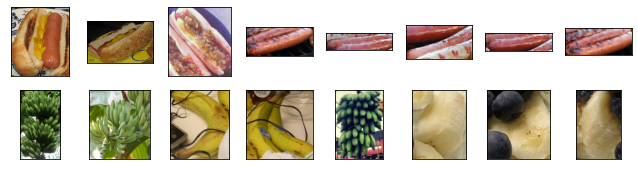

In [4]:
hotdogs = []
not_hotdogs = []
for i, (image, label) in enumerate(train_imgs.create_tuple_iterator()):
    if i < 8:
        hotdogs.append(image)
    elif i > train_imgs.get_dataset_size() - 9:
        not_hotdogs.append(image)
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [5]:
normalize = vision.Normalize(
    [0.485 * 225, 0.456 * 225, 0.406 * 225], [0.229 * 225, 0.224 * 225, 0.225 * 225])

train_augs = transforms.Compose([
    vision.RandomResizedCrop(224),
    vision.RandomHorizontalFlip(),
    normalize,
    vision.HWC2CHW()])

test_augs = transforms.Compose([
    vision.transforms.Resize([256, 256]),
    vision.transforms.CenterCrop(224),
    normalize,
    vision.HWC2CHW()])

In [6]:
import mindcv

pretrained_net = mindcv.create_model('resnet18', pretrained=True)

[WARNING] ME(4618:140498888794688,MainProcess):2023-02-15-19:03:43.644.476 [mindspore/common/api.py:824] 'mindspore.ms_class' will be deprecated and removed in a future version. Please use 'mindspore.jit_class' instead.
[WARNING] ME(4618:140498888794688,MainProcess):2023-02-15-19:03:43.662.539 [mindspore/common/api.py:678] 'mindspore.ms_function' will be deprecated and removed in a future version. Please use 'mindspore.jit' instead.
[WARNING] ME(4618:140498888794688,MainProcess):2023-02-15-19:03:43.663.985 [mindspore/common/api.py:678] 'mindspore.ms_function' will be deprecated and removed in a future version. Please use 'mindspore.jit' instead.


In [7]:
pretrained_net.classifier

Dense<input_channels=512, output_channels=1000, has_bias=True>

In [27]:
import mindspore.common.initializer as initializer

finetune_net = mindcv.create_model('resnet18', pretrained=True)
finetune_net.classifier = nn.Dense(finetune_net.classifier.in_channels, 2)
finetune_net.classifier.weight.set_data(
    initializer.initializer(initializer.XavierNormal(), finetune_net.classifier.weight.shape, finetune_net.classifier.weight.dtype))


Parameter (name=classifier.weight, shape=(2, 512), dtype=Float32, requires_grad=True)

In [25]:
# 如果param_group=True，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = ds.ImageFolderDataset(os.path.join(data_dir, 'train'), 
                                       shuffle=True, decode=True)
    train_iter = train_iter.map(train_augs, input_columns=["image"])
    train_iter = train_iter.batch(batch_size=batch_size)
    test_iter = ds.ImageFolderDataset(os.path.join(data_dir, 'test'), 
                                       shuffle=True, decode=True)
    test_iter = test_iter.map(test_augs, input_columns=["image"])
    test_iter = test_iter.batch(batch_size=batch_size)
    
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for param in net.get_parameters()
             if param.name not in ["classifier.weight", "classifier.bias"]]
        trainer = nn.SGD([{'params': params_1x},
                        {'params': net.classifier.get_parameters(),
                        'lr': learning_rate * 10}],
                        learning_rate=learning_rate, weight_decay=0.001)
    else:
        trainer = nn.SGD(net.get_parameters(), learning_rate=learning_rate,
                        weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs)

loss 0.205, train acc 0.918, test acc 0.931


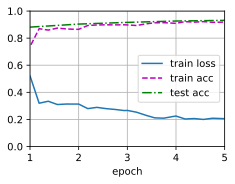

In [28]:
train_fine_tuning(finetune_net, 5e-5)

KeyboardInterrupt: 

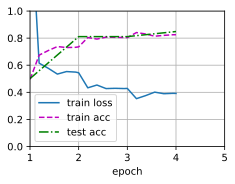

In [29]:
scratch_net = mindcv.create_model('resnet18')
scratch_net.classifier = nn.Dense(finetune_net.classifier.in_channels, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

In [33]:
for param in finetune_net.get_parameters():
    param = ops.stop_gradient(param)

In [37]:
weight = pretrained_net.classifier.weight
weight.data

Parameter (name=classifier.weight, shape=(2, 512), dtype=Float32, requires_grad=True)